# Стохастический анализ (2025)
# Домашнее Задание 2 (программная часть)

ВАШЕ ИМЯ ЗДЕСЬ

Оценка(итоговая за ДЗ): ?? из 100 + бонус(?)


Задачи: ?? из 50

Ноутбук: ?? из 50


Дедлайн:  13 февраля 2359МСК

Решённый ноутбук нужно засабмитить в Anytask курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW2.pdf или <Имя>HW2.ipynb. Например, KaledinHW2.pdf и KaledinHW2.ipynb.

In [1]:
#all imports here, please
import numpy as np
import sklearn.linear_model as sklin

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import tqdm as tqdm

## Новейший пылесос (50 баллов)

В подразделении Chasseurs de Poussière (СdP) одной известной компании разрабатывают интеллектуальные решения для уборки разного рода помещений(в основном, промышленных). Одна из их новейших разработок -- робот-пылесос, который умеет определять свои координаты на заданной дискретной сетке при помощи простейшей системы навигации и некоторым случайным образом объезжать помещение. Ваша задача -- оценить, насколько это техническое устройство хорошо, для этого придётся провести симуляции, собрать данные, а также привести некоторые выкладки.

### Описание устройства и экспериментов

Пылесос оснащён системой навигации, поэтому в каждый (дискретный) момент времени он может точно определить своё положение на карте помещения. Все помещения в серии экспериментов полагаются прямоугольными со сторонами $M \times N$ метров. Пылесос может совершать движение вперёд, назад, влево, вправо и по диагоналям на соседнюю дискретную клетку; он это делает равновероятно, выбирая из всех доступных направлений (около стен и в углах некоторые направления ему недоступны).

В каждый момент времени в каждой точке комнаты появляется пыль, её количество -- это случайная величина из распределения $Beta(2,5)$, в момент $t=0$ уровень пыли равен нулю во всех точках комнаты. Пылесос стартует из угла (скажем, из точки 0,0 ) и, проезжая по запылённому квадрату, собирает 90% накопившейся там пыли и немедленно её уничтожает в собственной системе переработки. 

#### Математическая модель

Опишите, как записать модель движения робота-пылесоса по комнате размера $M \times N$ с помощью цепи Маркова в дискретном времени с конечным числом состояний.

Эту модель можно представить в виде графа m*n вершинах. Зададим каждой клетке ее позицию ij. В 4 угловых вершинах вероятность перехода в соседнюю -- 1/3, в неугловых вершинах, где m или n равны 1 (вершины, образуюшие стороны прямоугольника), вероятность перехода -- 1/5, в остальных -- 1/8

Докажите, что пылесос задаёт эргодическую цепь.

Вспомним критерии эргодичности:
1) между двумя любыми вершинами найдется путь конечной длины. Т.к. граф связан и неоринтирован, число ребер конечно, тк число вершин конечно (m*n) => между любыми двумя вершинами найдется путь конечной длины
2) нет периодичных состояний.
Всего мы наблюдаем 3 типа вершин: 'угловые' (имеет 3 соседа), 'сторонообразующие' (5 соседей) и 'остальные' (8 соседей). Для любой вершины можно построить путь из самой в себя, как длины 3, так и длины 4, тк по построению графа все вершины образуют треуголники на 3 или 4 вершинах. Так как НОД(3,4) = 1 => все состояния апериодичны

Из п. 1-2 => цепь эргодическая

### Экспериментальная инфраструктура

В нашем эксперименте есть комната (с разными параметрами) и пылесос. Ещё нам понадобится отдельная сущность для проведения самого эксперимента. 

Можете использовать приведённый ниже код, модифицируя его под свои нужды.

Начнём с комнаты, тут всё просто. Комната обладает размерами, она же хранит количество пыли в разных местах и определяет динамику накопления пыли. Отдельно предусматриваем reset, чтобы можно было обновить экспериимент.

Ещё нам понадобятся агрегированные замеры пыли: максимальный размер пыли, суммарный и средний по комнате. Удобно их реализовать здесь, чтобы эксперимент мог легко их вычислять.

In [2]:
#Computer Model of Room

class Room:

    def __init__(self, M=3, N=3, alpha=2, beta=5):
        """Room class

        Args:
            M (int): size #1. Defaults to 3.
            N (int): size #2. Defaults to 3.
            alpha (int, optional): Alpha dust parameter. Defaults to 2.
            beta (int, optional): Beta dust parameter. Defaults to 5.
        """        
        self.M = M
        self.N = N

        self.time = 0
        self.dustMatrix = np.zeros([M,N]) #matrix with dust values

        self.alpha = alpha
        self.beta = beta

    def __str__(self):
        return f"Room(M={self.M}, N={self.N}, alpha={self.alpha}, beta={self.beta})"
        

    def addDust(self):
        '''
        Samples additional dust in all cells and increases time(!!)
        '''
        self.dustMatrix = self.dustMatrix + np.random.beta(a=self.alpha,b=self.beta, size=self.dustMatrix.shape)
        self.time = self.time + 1

    def removeDust(self, y, x):
        """Removes 90% of dust at cell y,x

        Args:
            y (int): y coord
            x (int): x coord
        """
        self.dustMatrix[y, x] *= 0.1    

    def reset(self):
        '''
        Resets the dust level and time to zero, used to reset the experiment
        '''
        self.time = 0
        self.dustMatrix[...] = 0

    def getAggregator(self,aggregator):
        """Computes aggregated value of dust

        Args:
            aggregator (func): aggregator function f: ndarray -> number (aka mean, amax,amin...)

        Returns:
            aggregation: aggregated value
        """        
        return aggregator(self.dustMatrix)
    

Не забываем тестировать.

In [3]:
#setup
M=3
N=4
alpha=2
beta=5
room = Room(M,N,alpha=alpha,beta=beta)
T=20
aggregators = {"Сред": np.mean, "Макс": np.amax}#"sumDust": np.sum }
dustDynamics = {key: np.zeros([T]) for key in aggregators.keys()} #saving the artefacts of the experiment

In [4]:
#experiment loop
room.reset()
for timeId in np.arange(T):
    for key,val in aggregators.items():
        dustDynamics[key][timeId] = room.getAggregator(val)
    room.addDust()

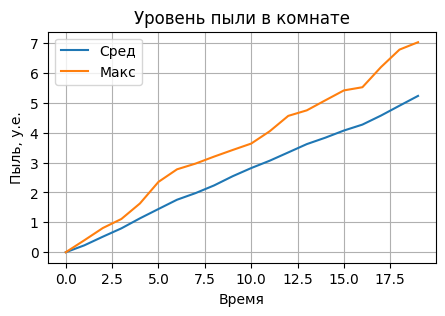

In [5]:
f,ax = plt.subplots(figsize=(5,3))

ax.grid()
ax.set_title("Уровень пыли в комнате")
ax.set_ylabel("Пыль, у.е.")
ax.set_xlabel("Время")
leg=[]
for key in dustDynamics.keys():
    ax.plot(np.arange(T),dustDynamics[key])
    leg = leg + [key]
ax.legend(leg)
plt.show()

### Пылесос

Далее нам понадобится пылесос. Как мы выяснили (надеемся), он задаёт эргодическую цепь Маркова. Для целей поиска инвариантного распределения нам ещё пригодится матрица.

Поскольку пылесос вообще может в теории по-разному принимать решения, сделаем для аккуратности абстрактное правило, TransitionRule. У нас оно будет одно -- марковское, на основе переходной матрицы, раз она у нас всё равно есть.

Вычисления переходной матрицы можно сделать наивным путём (~100 строк) либо собрать из 4d тензора вероятностей перехода из $i,j$ в $k,v$, но вам нужно будет подумать, как; получится около 30 строк.

In [6]:
class TransitionRule:
    def __init__(self):
        pass

class TransitionMatrixRule(TransitionRule):

    def __init__(self, transitionMatrix):
        '''
            Transition rule based on the fixed transition matrix
            Input
            float[][] transitionMatrix -- transition matrix, of shape (M,N)
        '''
        self.transitionMatrix = transitionMatrix

    def makeTransition(self, id):
        """Makes a transition

        Args:
            id (int): current id

        Returns:
            newId (int): new id
        """        
        pr = self.transitionMatrix[id]
        return np.random.choice(len(pr), p=pr)


class Cleaner:
    def __init__(self):
        pass


class UniformCleaner(Cleaner):

    def __init__(self, room):
        """Cleaner moving uniformly in all available directions

        Args:
            room (Room): room assigned 
        """       
        self.room = room

        self.x = 0 #we start in the corner
        self.y = 0

        self.createTransitionMatrix()
        
        self.transitionRule = TransitionMatrixRule(self.P)
        self.invComputed = False
        
    def reset(self):
        """
        Resets the cleaner
        """        
        self.x = 0 #we start in the corner
        self.y = 0

    def makeMove(self):
        """"
        Makes the robot moving
        """
        current_id = self._flatten(self.y, self.x)
        new_id = self.transitionRule.makeTransition(current_id)
        self.y, self.x = self._to_matrix_form(new_id)

    # Дополнительно можно добавить здесь код для взаимодействия уборщика с комнатой, например, очистку места

    def _flatten(self, position_i, position_j):
        return position_i*self.room.N + position_j
    
    def _to_matrix_form(self, id):
        return id//self.room.N, id%self.room.N
    
    def _shift(self, current_id, dx, dy):
        y, x = self._to_matrix_form(current_id)
        new_y = y + dy
        new_x = x + dx

        if 0 <= new_y < self.room.M and 0 <= new_x < self.room.N:
            return self._flatten(new_y, new_x)
        else:
            return None


    def createTransitionMatrix(self):
        """
        Creates the transition matrix
        """        
        M, N = self.room.M, self.room.N
        P = np.zeros((M*N, M*N), dtype=float)
        delta_x = [-1, 0, 1]
        delta_y = [-1, 0, 1]

        for y in range(M):
            for x in range(N):
                current_id = self._flatten(y, x)
                neighbours = []

                for dx in delta_x:
                    for dy in delta_y:
                        new_id = self._shift(current_id, dx, dy)
                        if new_id is not None and new_id != current_id:
                            neighbours.append(new_id)
                # print(f"neighbours for {current_id}",neighbours)
                num_neighbours = len(neighbours)
                if num_neighbours == 0:
                    P[current_id, current_id] = 1
                else:
                    for n_id in neighbours:
                        P[current_id, n_id] = 1/num_neighbours
        self.P = P


    def getInvariantDist(self, reshape=False):
        """Computes invariant distribution

        Args:
            reshape (bool, optional): Whether to reshape the result to (M,N) shape . Defaults to False.

        Returns:
            float[]: invariant distribution in raw form (reshape=False, (M*N,)) or reshaped
        """  
        if (not self.invComputed):
            eigenvalues, eigenvectors = np.linalg.eig(self.P.T)
            idx = np.argmin(np.abs(eigenvalues - 1.0))
            dist = np.real(eigenvectors[:, idx])
            dist = np.maximum(dist, 0)
            total = dist.sum()
            if total > 0:
                dist /= total
            else:
                dist = np.full_like(dist, 1.0 / dist.size)

            self.invDist = dist
            self.invComputed = True

        if reshape:
            return self.invDist.reshape((self.room.M, self.room.N))
        return self.invDist


In [7]:
room = Room(3, 2)
robot = UniformCleaner(room)
robot.createTransitionMatrix()

print(robot.P) 


[[0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333 0.         0.        ]
 [0.2        0.2        0.         0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.         0.2        0.2       ]
 [0.         0.         0.33333333 0.33333333 0.         0.33333333]
 [0.         0.         0.33333333 0.33333333 0.33333333 0.        ]]


Начнём тестирование. Важно всё проверить, потому что в размерностях очень легко ошибиться.

In [8]:
M=3
N=4
alpha=2
beta=5
room = Room(M,N,alpha=alpha,beta=beta)
cleaner = UniformCleaner(room)

Тестируем, как задаётся переходная матрица. Этот скрипт поможет вам нарисовать всё наглядно.

[[2 3 4]
 [1 2 3]
 [1 1 2]]


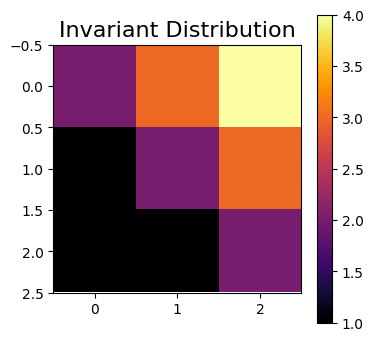

In [9]:
#just some example
transitionProbas = np.array([[2,3,4],[1,2,3],[1,1,2]])
print(transitionProbas)

f,ax = plt.subplots(figsize=(4,4))

ax.set_title("Invariant Distribution", fontsize=16)
imag=ax.imshow( transitionProbas, cmap="inferno")
f.colorbar(imag);

Теперь найдём инвариантное распределение (в классе это функция `getInvariantDist` ) с помощью инструментов `np.linalg`. Если можете аналитически -- напишите решение (у меня получилось;) ), сравните на картинке с численным и *можно получить +3 бонусных балла*.

ВАШ ТЕКСТ (если хотите попробовать аналитически)

In [10]:
invDist=cleaner.getInvariantDist(reshape=True) # numeric computation for the test room
print(invDist)

[[0.05172414 0.0862069  0.0862069  0.05172414]
 [0.0862069  0.13793103 0.13793103 0.0862069 ]
 [0.05172414 0.0862069  0.0862069  0.05172414]]


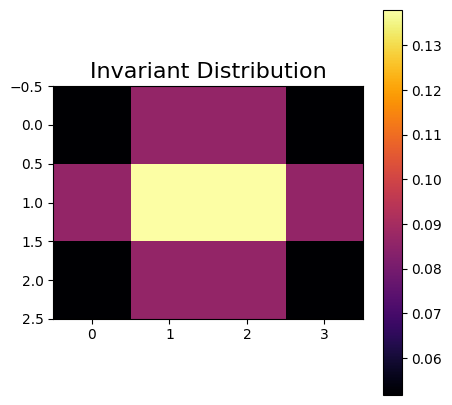

In [11]:
#plots
f,ax = plt.subplots(figsize=(5,5))

ax.set_title("Invariant Distribution", fontsize=16)
imag=ax.imshow( invDist, cmap="inferno")
f.colorbar(imag);

Прокомментируйте свой результат, насколько он сходится с вашими представлениями?

Результат сходится с моими предположениями: в случае бесконечного блуждания вероятность оказаться в углах меньше, чем по бокам и в середине, так как у угловых клеток 3 соседа, у сторонообразующих -- 5, а у центральных -- 8. Значит и попасть в последние, вероятность больше.

### Эксперимент с одним пылесосом

Целевой показатель уборки -- максимальный, средний и суммарный уровень пыли в комнате. Для нескольких разных комнат вычислите инвариантное распределение и проанализируйте динамику пыли. Используйте шаблоны кода, приведённые ниже, чтобы провести эксперимент в разных комнатах:

1. $M=5,N=5$, малая комната;
2. $M=15,N=15$, большая квадратная комната;
3. $M=5,N=15$, большая вытянутая комната;
4. $M=5,N=10$, средняя вытянутая комната;
4. $M=10,N=10$, средняя квадратная комната.

Это большой эксперимент. Чтобы это лаконично и контролируемо сделать, реализуем класс эксперимента, в котором как в конструкторе соберём всё вместе.

Экспериментальные данные будем сохранять в виде словаря, где ключи отвечают за агрегатор, а один особенный ключ ``dustLevel`` будет собирать карты пыли  во все моменты времени. Далее с этими данными можно исследовать, что произошло.

In [12]:
#Experiment class
class Experiment:

    def __init__(self, runName="TemplateRun", M=3, N=3, alpha=2, beta=5, nCleaners=1, aggregators=None):
        """Experiment class

        Args:
            runName (str, optional): run ID. Defaults to "TemplateRun".
            M (int, optional): size #1. Defaults to 3.
            N (int, optional): size #2. Defaults to 3.
            alpha (float, optional): alpha dust parameter. Defaults to 2.
            beta (float, optional): beta dust parameter. Defaults to 5.
            nCleaners (int, optional): number of cleaners to assign. Defaults to 1.
            aggregators (dict, optional): A dictionary of aggregator functions
        """        
        self.runName = runName
        self.room = Room(M=M, N=N, alpha=alpha, beta=beta)
        self.cleaners = [UniformCleaner(self.room) for _ in np.arange(nCleaners)]
        if(aggregators is None):
            self.aggregators = {"meanDust": np.mean}
        else:
            self.aggregators = aggregators

    def __str__(self):
        return f"Experiment Room:{str(self.room)} \n Cleaners = {str(self.cleaners)}"
    
    def resetExperiment(self):
        '''
        Returns the cleaners to the start position and resets the room
        '''
        self.room.reset()
        for cleaner in self.cleaners:
            cleaner.reset()


    def makeOneRun(self, maxTime=1000):
        
        self.resetExperiment()
        
        results = {key: np.zeros([maxTime]) for key in self.aggregators.keys() }#init
        results.update({"dustLevel": np.zeros([maxTime,self.room.dustMatrix.shape[0],self.room.dustMatrix.shape[1]]) })#init
        for t in tqdm.tqdm(np.arange(maxTime),desc="Experiment run...."):
            results["dustLevel"][t,...] = self.room.dustMatrix.copy()

            for cleaner in self.cleaners:
                cleaner.makeMove()
                self.room.removeDust(cleaner.y, cleaner.x)

            for key, f in self.aggregators.items():
                results[key][t] = self.room.getAggregator(f)

            self.room.addDust()

        return results
        

    def makeManyRuns(self, maxTime=1000, nExperiments=1):
        '''
        Returns nExperiments sequences of dust amounts, each of length maxTime
        Input
        int maxTime -- the time when the experiment stops
        int nExperiments -- number of experiments to run
        Returns
        np.array of shape (nExperiments,maxTime), sequence of dust levels in the set of the experiments
        '''
        results_experiments = []
        for _ in tqdm.tqdm(range(nExperiments), desc="Running experiments"):
            r = self.makeOneRun(maxTime=maxTime)
            results_experiments.append(r)
        return results_experiments

Теперь к большому эксперименту (начните с маленького, чтобы протестировать пайплайн).

Задайте конфигурацию и отправьте считать.

В качестве результатов замерьте

1. Уровень пыли в каждой точке комнаты в каждый момент времени
2. Средний уровень пыли в комнате в каждый момент времени
3. Максимальный уровень пыли в комнате в каждый момент времени

Это понадобится для графиков, которые ниже.

In [13]:
#INIT
aggregators = {"meanDust": np.mean, "maxDust": np.amax, "sumDust": np.sum}
alpha = 2
beta = 5

configs = [
        {"runName": "5*5", "M": 5, "N": 5, "alpha": 2, "beta": 5, "nCleaners": 1},
        {"runName": "15*15", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 1},
        {"runName": "5*15", "M": 5, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 1},
        {"runName": "5*10", "M": 5, "N": 10, "alpha": 2, "beta": 5, "nCleaners": 1},
        {"runName": "10*10", "M": 10, "N": 10, "alpha": 2, "beta": 5, "nCleaners": 1},
    ]

Experiments = [Experiment(aggregators=aggregators, **config) for config in configs]
results = {}
nRuns=10
maxTime=1000

for experiment in Experiments:
    print(f"Experiment: {experiment.runName}")
    results[experiment.runName] = experiment.makeManyRuns(maxTime=maxTime, nExperiments=nRuns)


Experiment: 5*5


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 20.32it/s]


Experiment: 15*15


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 10.11it/s]


Experiment: 5*15


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]


Experiment: 5*10


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


Experiment: 10*10


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s]


Отлично, теперь давайте изучим результаты.

In [14]:
def processExperimentData(exp):
    """_summary_

    Args:
        exp (list): list of dicts (one run results)

    Returns:
        res: dict with averged in runs results
    """    
    res = {}
    keys = exp[0].keys()
    
    for key in keys:
        data = [run[key] for run in exp]
        stack_data = np.stack(data, axis=0)
        res[key] = np.mean(stack_data, axis=0)
    
    return res

In [18]:
expProcessed = {
    name: processExperimentData(exp_runs)
    for name, exp_runs in results.items()
}

Отобразите средний и максимльный уровень пыли в зависимости от времени в каждой комнате. Усредните результаты по повторяющимся запускам (если вы не сделали этого выше). Как ведёт себя уровень пыли в зависимости от конфигурации комнаты?

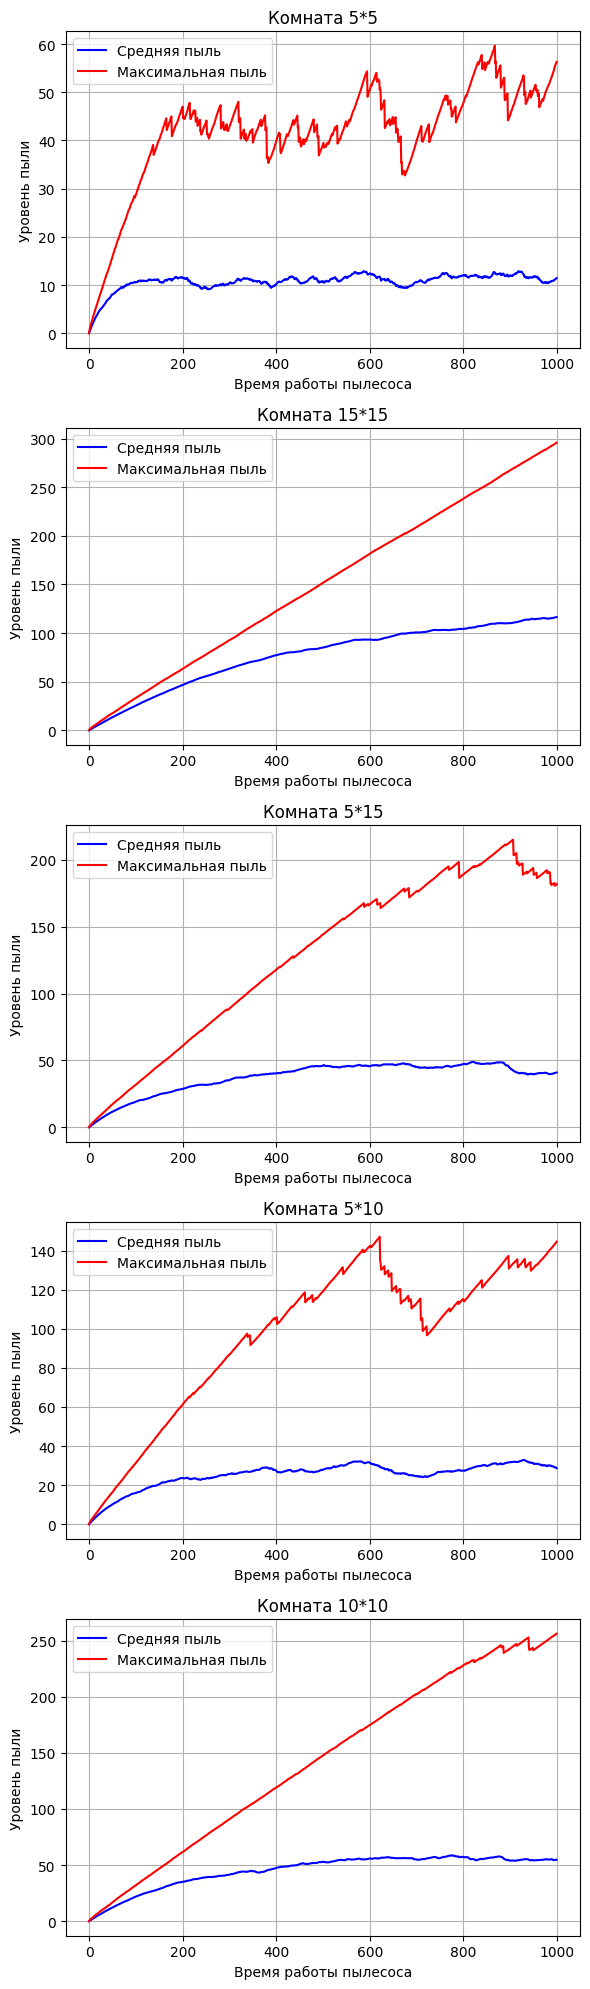

In [19]:
f, axs = plt.subplots(len(expProcessed), 1, figsize=(6, 4 * len(expProcessed)))
if len(expProcessed) == 1:
    axs = [axs]

for idx, (name, data) in enumerate(expProcessed.items()):
    ax = axs[idx]
    ax.plot(data["meanDust"], label="Средняя пыль", color="blue")
    ax.plot(data["maxDust"], label="Максимальная пыль", color="red")

    ax.set_title(f"Комната {name}")
    ax.set_xlabel("Время работы пылесоса")
    ax.set_ylabel("Уровень пыли")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

Нетрудно заметить, что со временем средний уровень пыли остается приблизительно на одинаковом уровне, в то время как максимальный уровень растет. Это может служить подтверждением того, что пылесос убирает помещение неравномерно: он моет чаще центральную часть комнаты, оставляя в углах пыль.

Интересно отдельно посмотреть на то, сколько в среднем пыли в комнате в разных местах, выведите уровень пыли в моменты $t=20$, $t=200$, $t=1000$ в виде карты. В каких местах больше всего скапливается пыли? Объясните ваши результаты.

In [20]:
room_config = {"runName": "3x30", "M": 3, "N": 30, "alpha": 2, "beta": 5, "nCleaners": 1}
aggregators = {"meanDust": np.mean, "maxDust": np.amax, "sumDust": np.sum}
experiment = Experiment(aggregators=aggregators, **room_config)

nRuns = 10
maxTime = 1000
raw_results = experiment.makeManyRuns(maxTime=maxTime, nExperiments=nRuns)

expProcessed["3x30"] = processExperimentData(raw_results)

Running experiments: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s]


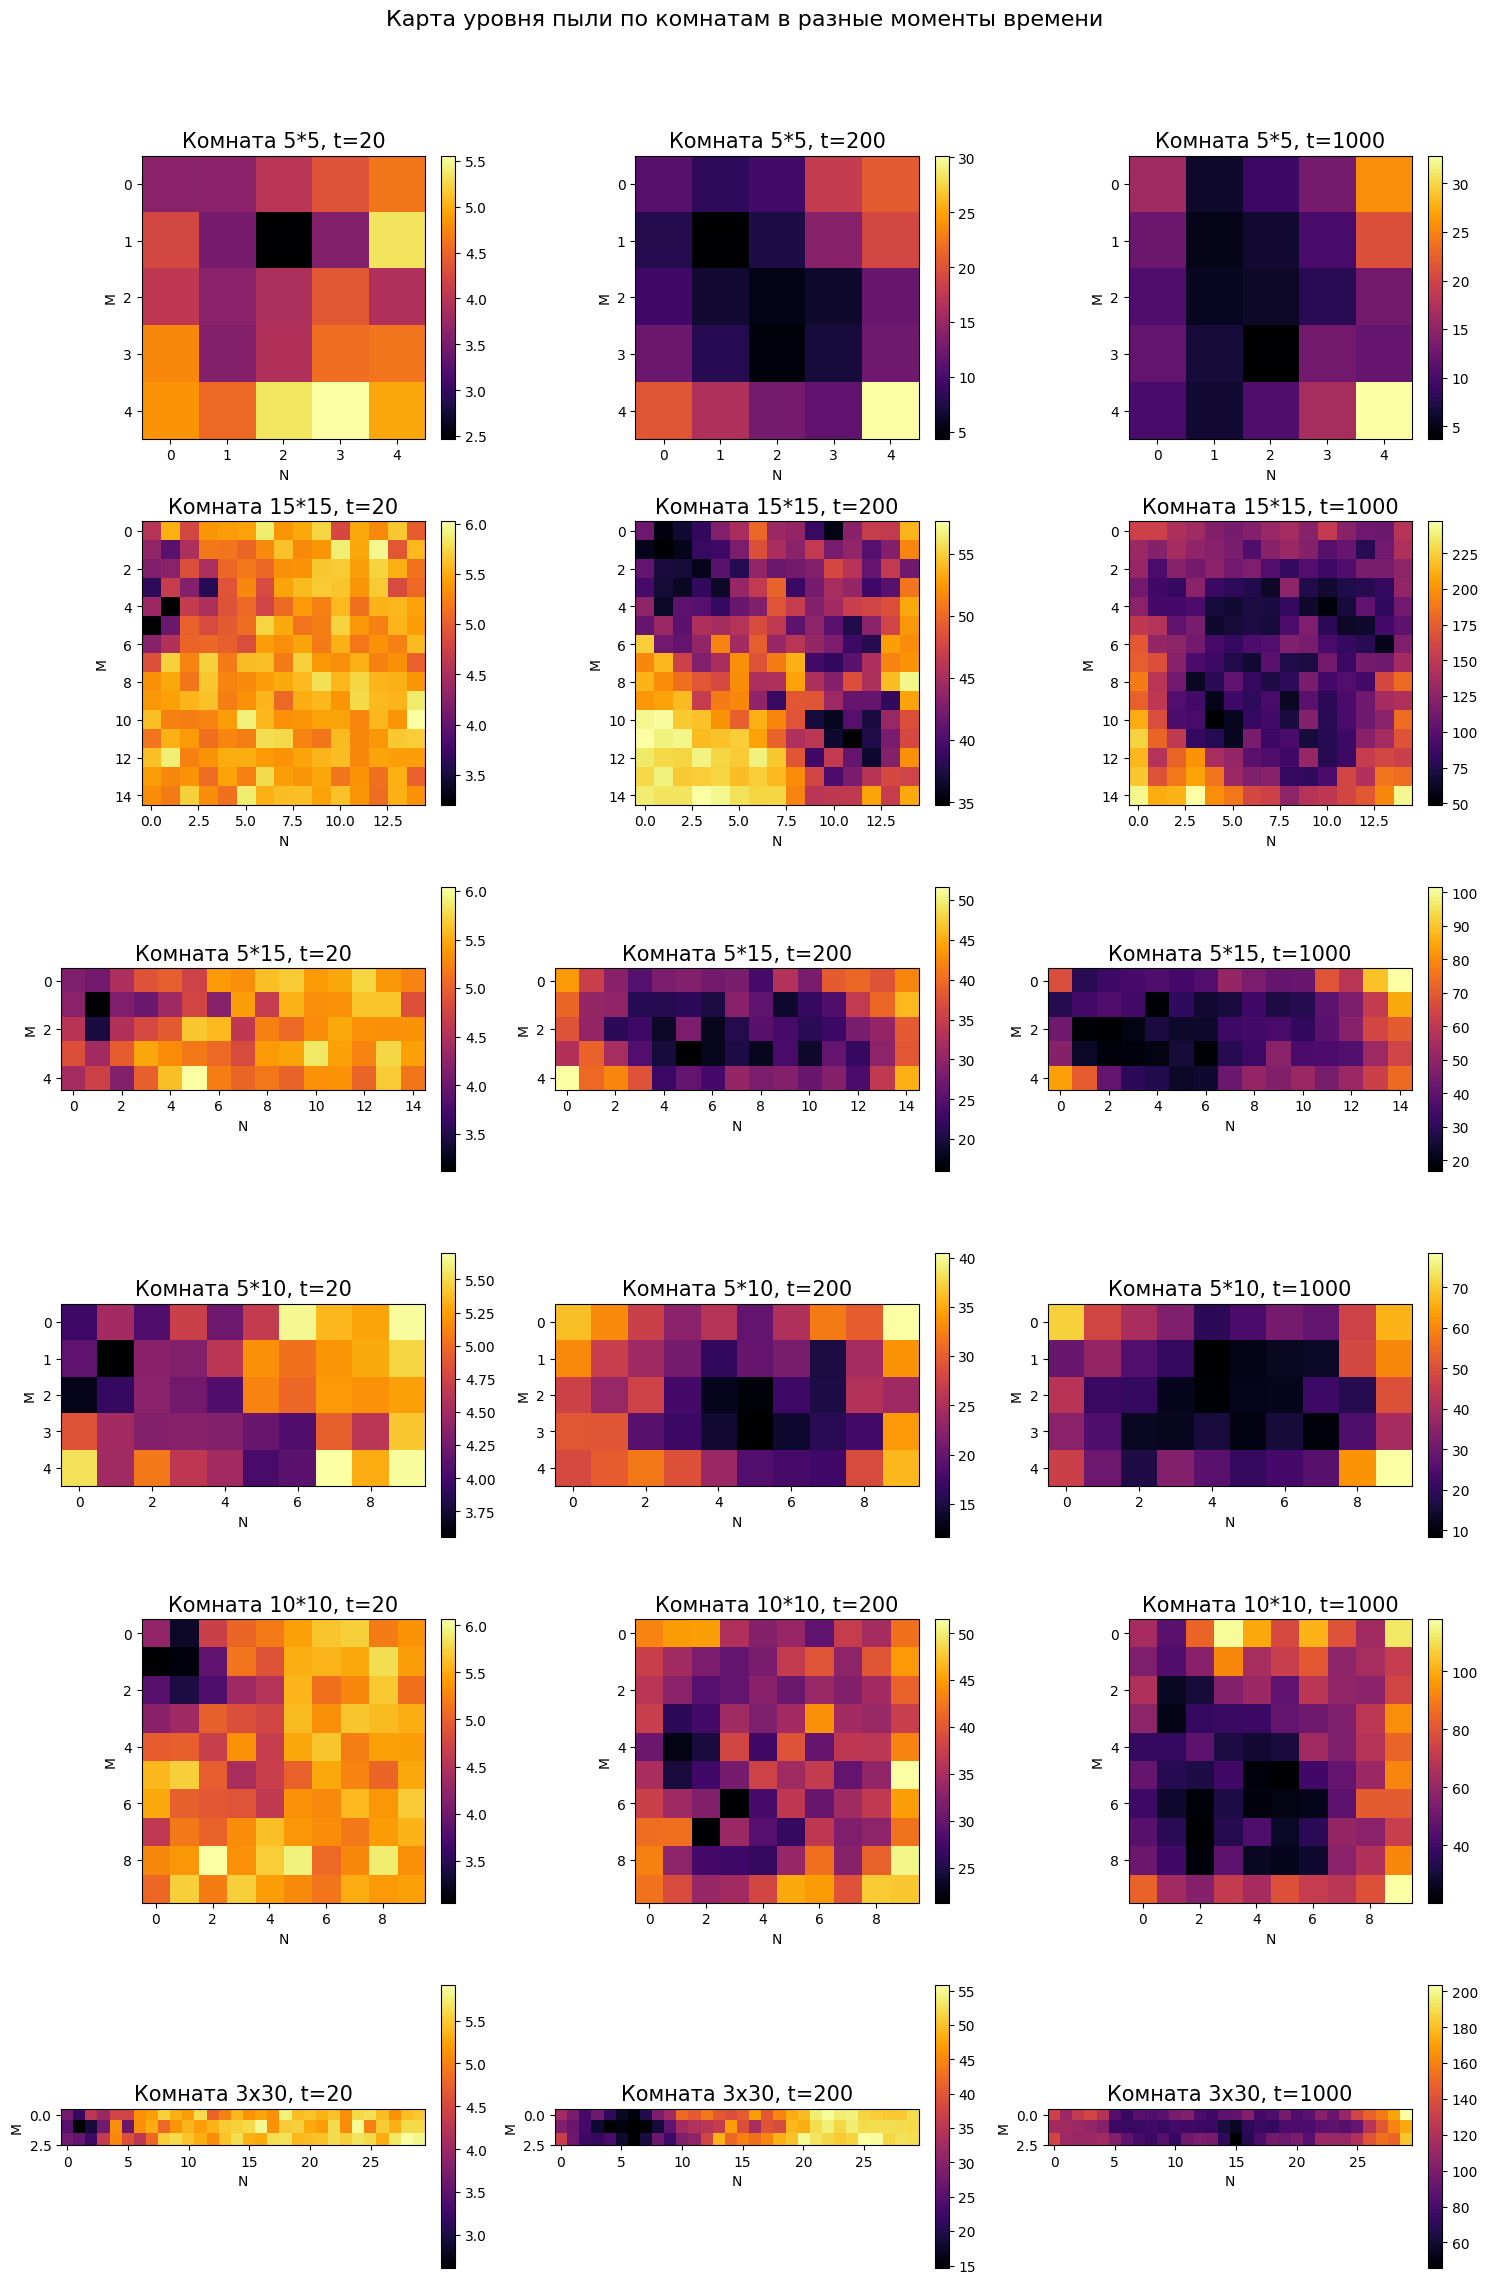

In [21]:
time_slices = [19, 199, 999]
n_rows = len(expProcessed)
n_cols = len(time_slices)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

if n_rows == 1:
    axs = [axs]

fig.suptitle("Карта уровня пыли по комнатам в разные моменты времени", fontsize=16)

for row_idx, (name, data) in enumerate(expProcessed.items()):
    for col_idx, t in enumerate(time_slices):
        ax = axs[row_idx][col_idx] if n_rows > 1 else axs[col_idx]
        dust_slice = data["dustLevel"][t]
        im = ax.imshow(dust_slice, cmap="inferno")

        ax.set_title(f"Комната {name}, t={t+1}", fontsize=15)
        ax.set_xlabel("N")
        ax.set_ylabel("M")
        ax.grid(False)

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Как и ожидалось, большая часть пыли скапливается по углам, так как доступ к этим частям комнаты затруднен.

#### Длинный пример

Попробуйте запустить эксперимент на очень длинной большой комнате $M=3,N=30$.

Как геометрия комнаты влияет на динамику накопления пыли?

Длинная комната изображена на графике выше. Нетрудно заметить, что, находясь в длинной комнате, пылесос в основном ездит по одному и тому же участку, оставляя большое количество пыли по бокам. Находясь в комнате непродолжительное временя, один пылесос убирает ее не очень хорошо.

### Много пылесосов?..

Теперь мы знаем, что в больших комнатах один пылесос не очень успешен. Если мы говорим об алгоритме, который 1 минуту чистит квадрат 1 метр, то мы можем умереть от пыли раньше, чем  пылесос выйдет на свой стационарный режим.

Логичный вопрос: а что если мы добавим несколько пылесосов? Эта возможность предусмотрена в нашем экспериментальном классе. Для простоты, чтобы избежать вопросов коллизий мы предположим, что пылесосы(технологичные) устроены так, что они не сталкиваются и если оказываются в одном квадрате, то чистят его вместе. Математически это означает, что несколько пылесосов в один момент времени могут находится в одной точке комнаты.

Используя написанный экспериментальный пайплайн, ответьте на следующий вопрос: сколько нужно использовать пылесосов в комнате 15 на 15, чтобы максимальный уровень пыли в среднем не превышал отметки в 200 у.е.?

Можно ли так исправить ситуацию с плохой уборкой в большой длинной комнате?

Подкрепите свои соображения экспериментом.

In [28]:
aggregators = {"maxDust": np.amax, "meanDust": np.mean, "sumDust": np.sum}
configs_many_cleaners = [
    {"runName": "15x15 with 1 cleaner", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 1},
    {"runName": "15x15 with 2 cleaners", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 2},
    {"runName": "15x15 with 4 cleaners", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 4},
    {"runName": "15x15 with 8 cleaners", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 8},
    {"runName": "15x15 with 16 cleaners", "M": 15, "N": 15, "alpha": 2, "beta": 5, "nCleaners": 16}
]

nRuns = 10
maxTime = 1000

experiments_many_cleaners = [Experiment(aggregators=aggregators, **config) for config in configs_many_cleaners]

results = {} 
for exp in experiments_many_cleaners:
    print(f"experiment: {exp.runName}")
    res = exp.makeManyRuns(maxTime=maxTime, nExperiments=nRuns)
    results[exp.runName] = res

experiment: 15x15 with 1 cleaner


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


experiment: 15x15 with 2 cleaners


Running experiments: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


experiment: 15x15 with 4 cleaners


Running experiments: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


experiment: 15x15 with 8 cleaners


Running experiments: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


experiment: 15x15 with 16 cleaners


Running experiments: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


In [33]:
expProcessed = {
    name: processExperimentData(exp_runs)
    for name, exp_runs in results.items()
}

for config in configs_many_cleaners:
    name = config["runName"]
    proc = expProcessed[name]
    final_max = proc["maxDust"][-1]
    print(f"exp {name}: максимальный уровень пыли в момент времени {maxTime} составляет {final_max:.2f}")


exp 15x15 with 1 cleaner: максимальный уровень пыли в момент времени 1000 составляет 296.46
exp 15x15 with 2 cleaners: максимальный уровень пыли в момент времени 1000 составляет 290.93
exp 15x15 with 4 cleaners: максимальный уровень пыли в момент времени 1000 составляет 208.09
exp 15x15 with 8 cleaners: максимальный уровень пыли в момент времени 1000 составляет 111.66
exp 15x15 with 16 cleaners: максимальный уровень пыли в момент времени 1000 составляет 52.60


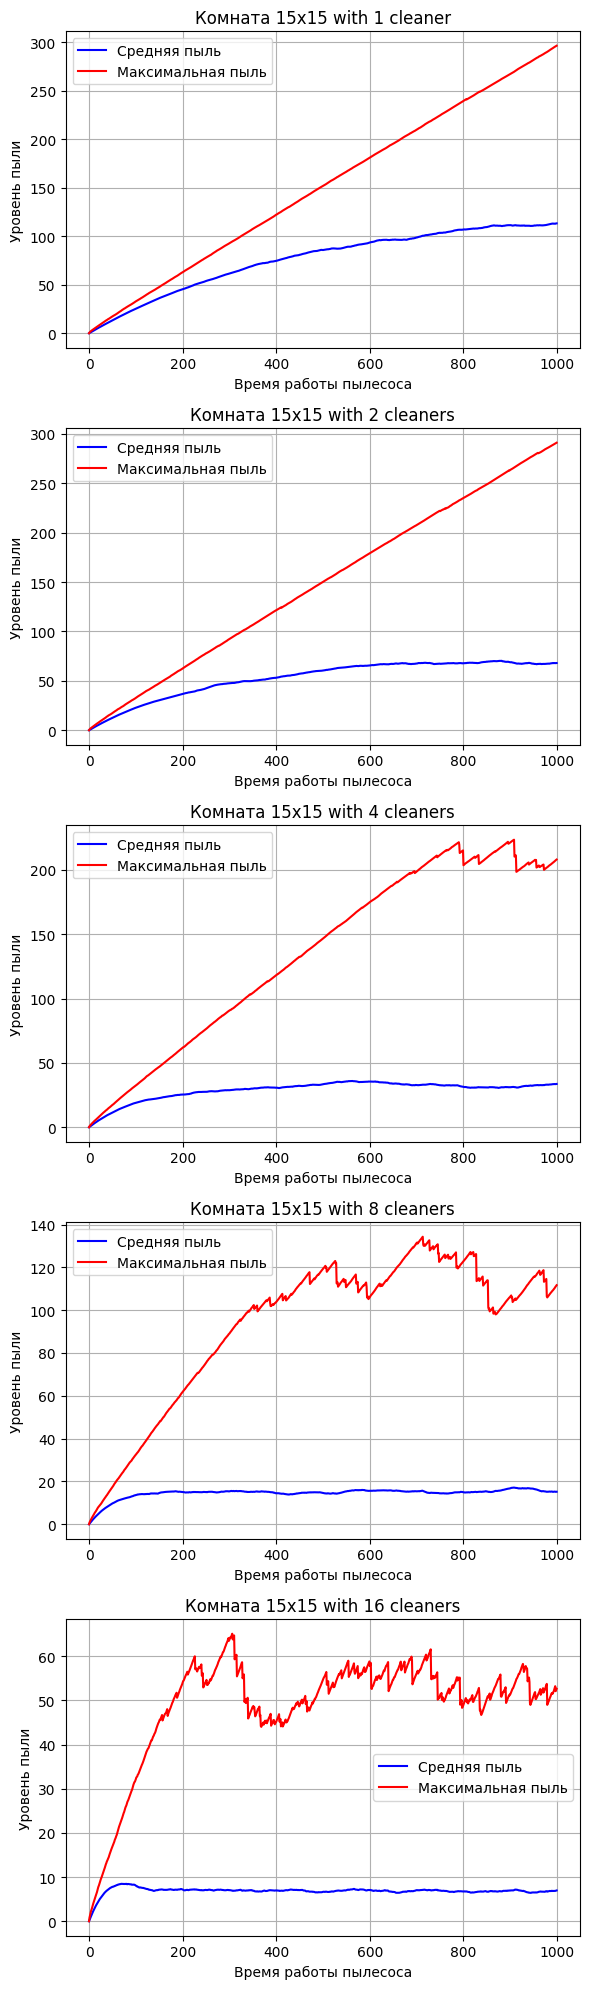

In [34]:
f, axs = plt.subplots(len(expProcessed), 1, figsize=(6, 4 * len(expProcessed)))
if len(expProcessed) == 1:
    axs = [axs]

for idx, (name, data) in enumerate(expProcessed.items()):
    ax = axs[idx]
    ax.plot(data["meanDust"], label="Средняя пыль", color="blue")
    ax.plot(data["maxDust"], label="Максимальная пыль", color="red")

    ax.set_title(f"Комната {name}")
    ax.set_xlabel("Время работы пылесоса")
    ax.set_ylabel("Уровень пыли")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

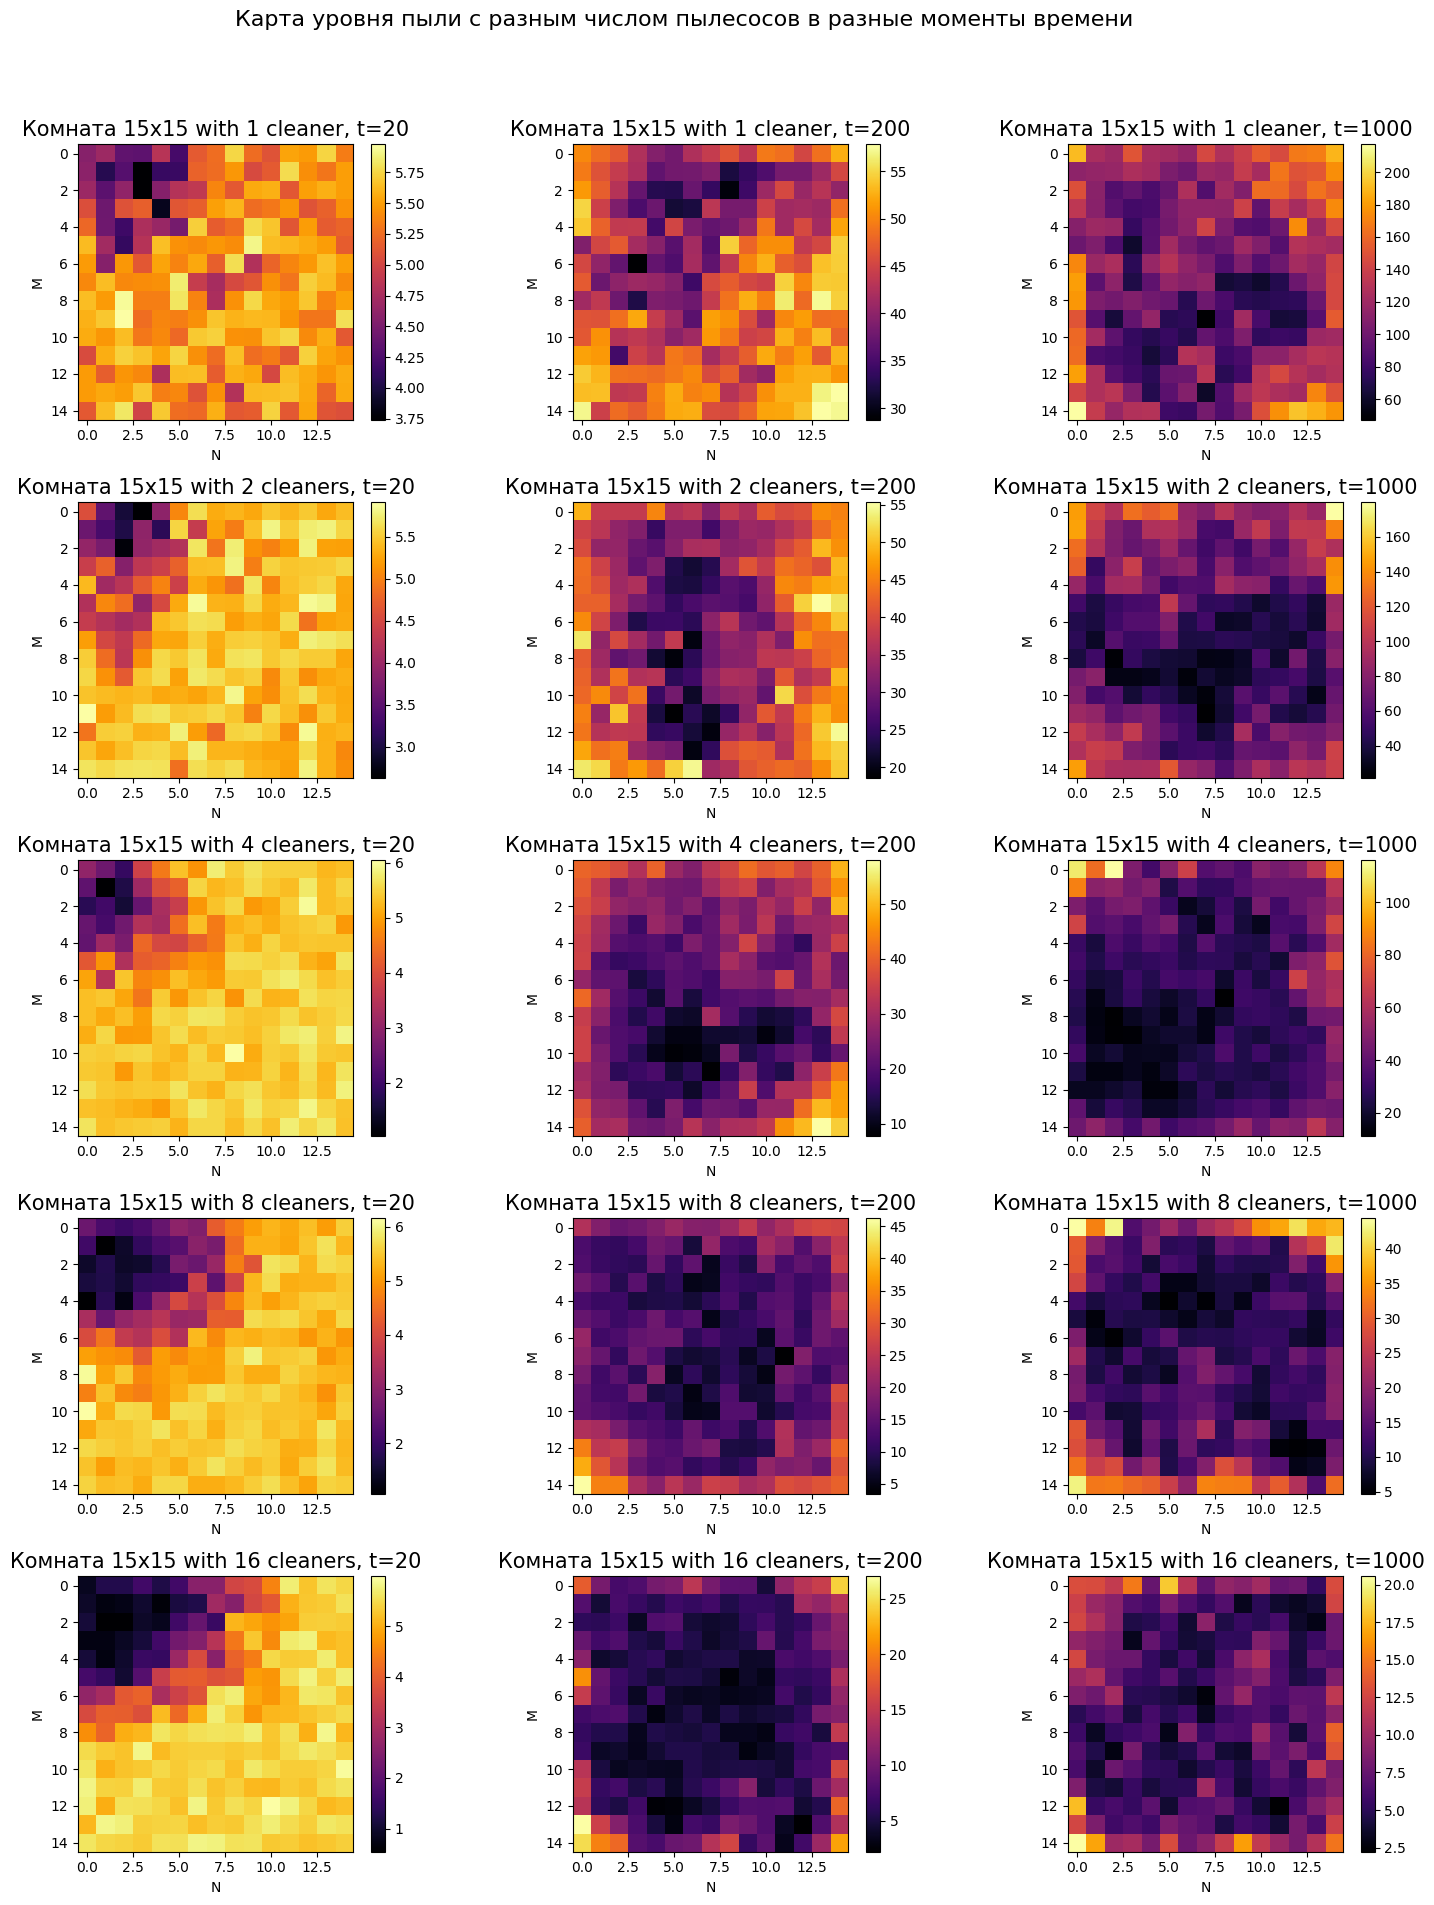

In [36]:
time_slices = [19, 199, 999]
n_rows = len(expProcessed)
n_cols = len(time_slices)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

if n_rows == 1:
    axs = [axs]

fig.suptitle("Карта уровня пыли с разным числом пылесосов в разные моменты времени", fontsize=16)

for row_idx, (name, data) in enumerate(expProcessed.items()):
    for col_idx, t in enumerate(time_slices):
        ax = axs[row_idx][col_idx] if n_rows > 1 else axs[col_idx]
        dust_slice = data["dustLevel"][t]
        im = ax.imshow(dust_slice, cmap="inferno")

        ax.set_title(f"Комната {name}, t={t+1}", fontsize=15)
        ax.set_xlabel("N")
        ax.set_ylabel("M")
        ax.grid(False)

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Чем больше пылесосов, тем меньше пыльных углов остается. Логичное предположение подтвердилось :)

## Американские опционы: верхняя оценка (Неоцениваемая часть, для инфо)

Вспомним задачу из ДЗ-1, где мы оценивали бермудский опцион с помощью регрессионных методов. Как в классическом машинном обучении, мы обучали модели и тестировали их на отложенной выборке. У нас получалась смещённая в верх оценка на трейне и честная нижняя оценка на тестовой выборке.

Функция ценности (она же функция Беллмана) -- это для задачи оптимальной остановки есть функция

$$
V_i(x) = f(x) \wedge \mathbb{E}\left[ e^{-r\Delta t} V_{i+1}(X_{i+1}) ~\vert~X_i=x\right].
$$

Если мы её знаем, мы можем построить оптимальное правило остановки: при уровне цен в момент $t$ равном $x_t$ смотрим на 
$$
С_t(x_t)=\mathbb{E}\left[ e^{-r\Delta t} V_{i+1}(X_{t+1}) ~\vert~X_t=x_t\right].
$$
Это ожидаемый выигрыш от оптимального продолжения ожидания. Если он больше текущего выигрыша $f(x_t)$, то мы должны продолжать, иначе исполняем опцион.

Это задаёт оптимальный момент остановки
$$
\tau_\star = \mathrm{inf}\left\lbrace~t: C_t(X_t) > f(X_t) \right\rbrace
$$
относительно фильтрации $(\mathcal{F}^X_t)$, порождённой процессом $X$, то есть, относительно актуальной истории наблюдений.


В отличие от классики, мы можем построить верхнюю оценку для цены опцииона и это совсем не типичная возможность для машинного обучения.

### Построение верхней оценки

Здесь нам пригождается теория мартингалов и идея очень проста.

Рассмотрим ожидаемый выигрыш от оптимального испольнения опциона

$$
\mathbb{E}\left[ e^{-r\tau_*} f(X_{\tau_*})\right].
$$
Если нам интересна только цена опциона и не интересно правило принятия решения -- это именно то число, которое мы хотели бы знать.

#### Новый мартингал (?? баллов)

Пусть $(M_t)$ -- мартингал относительно фильтрации $(\mathcal{F}_t^X)$ с нулевым средним $\mathbb{E}\left[ M_t \right]=0$. Обозначим множество таких процессов за $\mathcal{M}$. Докажите с помощью теоремы о свободном выборе, что

$$
\mathbb{E}\left[ e^{-r\tau_*}f(X_{\tau_*})\right] \leq \inf_{M \in \mathcal{M}} \mathbb{E}\left[ \max_{t=1,..,T} \left(e^{-r t}f(X_t) - M_t\right) \right].
$$

ВАШ ТЕКСТ

На самом деле, имеет место результат типа двойственности: точное равенство при некоторых условиях. Это показано в статье ``Rogers, L.C.G., Monte Carlo valuation of American options. Math. Finance, 2002``, сейчас всё ещё выходят работы, которые развивают эти идеи ещё дальше, например ``Belomestny, D., & Schoenmakers, J. (2023). From optimal martingales to randomized dual optimal stopping. Quantitative Finance, 23(7–8), 1099–1113. doi:10.1080/14697688.2023.2223242``.

Двойственная задача в данном случае сильно сложнее, чем прямая, но неравенство позволяет нам строить верхние оценки, если мы выберем хотя бы какой-нибудь подходящий мартингал $M \in \mathcal{M}$.

### Метод построения подходящего мартингала (?? баллов)

Изначальная идея была в том, чтобы использовать то, что уже есть: аппроксимацию значений $\hat{C}_t(x)$ из регрессионного метода. Для начала рассмотрим

$$
Y_t = V_t(X_t) - \mathbb{E}\left[ V_t(X_t) ~\vert~X_{t-1}\right].
$$

У величины $Y_t$ нулевое среднее (попробуйте взять полное матожидание). Более того, процесс

$$
M_t = \sum_{j=1}^t Y_j
$$

явлется мартингалом. Докажите.

ВАШ ТЕКСТ

Следующий шаг. Вспомним, что

$$
V_t(X_t) = \max \left( f(X_t), e^{-r\Delta_t}\mathbb{E}\left[ V_{t+1}(X_{t_+1} ~\vert~ X_t)\right]\right)
$$

и используем наши новые процессы:

$$
V_{t+1}(X_{t+1}) = Y_{t+1} + \mathbb{E}\left[ V_t(X_t) ~\vert~ X_{t-1}\right].
$$

Покажите по индукции, что

$$
V_t(X_t) = \max \left\lbrace f(X_t),~ e^{-r \Delta} \left(f(X_{t+1}) - Y_t\right), ~e^{-2 r \Delta} \left(f(X_{t+2}) - Y_{t+1} - Y_{t}\right),~ ...,~ e^{-(T-t) r \Delta} \left( f(X_{T}) - Y_{T} - Y_{T-1} - ... Y_{t+1}\right)\right\rbrace.
$$

ВАШ ТЕКСТ

Теперь покажите с использованием этого результата, что в начальный момент

$$
V_0(X_0) = \max_{t=1,..,T} \left[ e^{-rt}(f(X_t) - M_t)\right].
$$

### Как это использовать?

Заметим, что свыше значений $Y_t$ не дано и вычислять сложные матожидания выше мы не умеем, но от нас не требуется точности, нам нужен хотя бы какой-то мартингал. Как идею, можно попробовать 

$$
\hat{Y}_t = \hat{V}_t(X_t) -  \hat{C}_{t-1}(X_{t-1}),
$$

используя доступные нам методы из ДЗ-1. Однако, нет никаких гарантий, что для приближённых значений (которые мы умеем считать из ДЗ-1)

$$
\hat{C}_{t-1}(X_{t-1}) \approx \mathbb{E} \left[ V(X_{t}(X_{t})) ~\vert~ X_{t-1}\right]
$$

будет верно

$$
\mathbb{E}\left[ \hat{Y}_t ~\vert~ \mathcal{F}_t \right] = 0,
$$

поэтому 

$$
\hat{M}_t = \sum_{i=1}^t \hat{Y}_i
$$

не обязательно мартингал. Оказывается даже, что обязательно не мартингал. В итоге, такой процесс не подойдёт. Чтобы починить эту проблему, нам нужно подумать о том, что использовать в $\hat{Y}_t$ вместо второго члена. 

Предлагается достаточно интересное решение: давайте оценим матожидание отдельно, используя дополнительные одношаговые симуляции $\tilde{X}_{t}^{p}$ из условного распределения процесса при условии $X_{t-1}$ У выражения

$$
\hat{Y}_t = \hat{V}_t(X_t) -  \frac{1}{K}\sum_{j=1}^K\hat{V}_{t}(\tilde{X}^j_{t}).
$$

Для траектории $X_t^{(i)}$ набор семплов для оценки справа берётся из распределения $p(\cdot \vert X_{t-1}^{(i)})$.


По сути, из каждого значениия $X_t$ на шаге $t$ нужно выпустить $K$ вспомогательных семплов, а потом использовать их уже после регрессионной оценки значений $\hat{V}$ для построения верхней оценки





### Эксперименты (?? баллов)

Будем проводить эксперимент в том же сеттинге, что и в ДЗ-1. Вам очень пригодятся ваши наработки, если вы приняли решение не делать ту часть ДЗ, то вам придётся реализовать всё с нуля, в противном случае метод не заведётся.

##

#### Симулятор траекторий GBM

In [ ]:
def simulateWienerProcessMultivar(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float[] x0 -- initial value (d,)
    float[] ts -- times (T,)
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,d,len(ts))
    '''

    #YOUR CODE, see the code in the beginning and modify it

class GBMModelMultivar:
    '''
        Implements Geometric Brownian Motion, allowing for parameter estimation and simulations
    '''

    def __init__(self, mu=0,sigma=1):
        '''
        Input
        float[] mu -- drift parameter (if pre-defined) (d,)
        float[] sigma -- volatility (if pre-defined) (d,)
        '''
        self.mu=mu
        self.sigma=sigma

    def simulate(self,x0,ts,Ntraj):
        '''
        Simulates trajectories of GBM with set mu and sigma
        Input
        float x0 -- initial price
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        float confLevel -- confidence level, set to non-zero if confInterval is needed
        Returns
        float[] of shape (Ntraj,len(ts)) , trajectories
        if confLevel!=0, 
        then returns  float[] (Ntraj,len(ts)), float[] (len(ts),), float[] (len(ts),) 
        which are trajectories, confidenceLow, confidenceHigh
        '''

        #YOUR CODE
        raise NotImplemented       
    
    def oneStepSimulation(self,x0,dt):
        #N,K,d
        #YOUR CODE
        raise NotImplementedError

#### Функция ценности и метод оценки

In [ ]:

class ValueFunction:

    def __init__(self):
        '''
        Input
        Obj model -- object implementing methods fit() and predict(), may contain sklearn or torch models
        '''
        #as example
        self.model = sklin.LinearRegression(fit_intercept=False)
        self.featureTransform = #??
        self.FTFit = False

    def fit(self,X,y):
        '''
        Fits continuation value
        Input
        float[][] X -- training set of shape (batch, d)
        float[] y -- training targets of shape (batch,)
        '''
        if(not self.FTFit):
            self.featureTransform.fit(X)
            self.FTFit = True
        self.model.fit(self.featureTransform.transform(X),y)
        
    def predict(self,X):
        '''
        Predicts continuation value given current price vectors X
        Input
        float[][] X -- set of price vectors of shape (batch, d)
        Returns
        float[] contValues (batch,)
        '''
        if(self.FTFit):
            return self.model.predict(self.featureTransform.transform(X))
        else:
            return self.model.predict(self.featureTransform.fit_transform(X))

    def getParameters(self):
        return self.model.coef_


In [ ]:

class OptionPricer:

    '''Base class for option pricing'''

    def __init__(self,priceModel,payment,executionTimes,discountFunction):
        '''
        Input
        Obj priceModel -- GBMModel serving as simulator
        functionHandler payment -- function taking X (batch,d) and returning payments f(X) of shape (batch,)
        float horizon -- expiration time(in years)
        float[] executionTimes -- times when it is possible to execute the option
        functionHandler discountFunction -- function returning discounting rate based on the time (classic is e^{-r*h} like above)
        '''
        self.priceModel = priceModel
        self.payment = payment
        self.executionTimes = executionTimes
        self.continuationModels = [ValueFunction()]*(len(executionTimes)-2)
        self.discountFunction = discountFunction



    def computeHighBiasEstimator(self,Ntrajs,x0,saveTraj=False):
        '''
        Trains value functions and computes highBias estimator of the price
        Input
        int Ntrajs -- number of trajectories to sample
        Returns
        price, priceStd -- price estimation and estimated standard deviation
        '''
        #YOUR OLD CODE HERE
        #return priceMean, priceStd

    def computeLowEstimator(self,Ntrajs,x0):
        '''
        Computes low estimate of the price based on trained value functions and new sampled test set of trajectories
        Input
        int Ntrajs -- number of trajectories to use for estimation
        Returns
        priceLow,priceLowStd -- low estimation of the price and its estimated standard deviation
        '''
        #YOUR OLD CODE HERE
        
    def computeUpperEstimator(self,K=5):
        """Computes the upper estimator assuming saved trajectories and vs at self.upperTrajs and self.vs

        Args:
            K (int, optional): Number of nested simulations. Defaults to 5.

        Returns:
            meanEst (float): upper estimate mean
            stdEst (float): upper estimate std
        """        
        #YOUR CODE         
            


### Сравниваем с предыдущими результатами

В качестве иллюстрации метода, рассмотрим три пример с функцией выплаты $f(x) = (\max_i x_i - K)_+$ (американский max-put опцион со страйком $K=100$) для двух акций $X^1,X^2$ с начальными ценами

1. $X_0= [100,100]$;
2. $X_0= [110,110]$;
3. $X_0= [90,90]$.

Параметры модели: банковская процентная ставка $r=0.05$ годовых, для каждой акции дивиденды $\delta=0.1$ годовых, волатильность $\sigma=0.2$, истечение срока опциона $T=1$ год. Используется геометрическое Броуновское движение с параметрами $\mu=r-\delta$ и $\sigma$, шаг дискретизации $0.1$ (число разбиений равно $10$). Max-put опцион позволяет продать товар из корзины, который имеет максимльную цену в момент исполнения, по цене страйка $K$.

Для каждого из трёх сценариев проведите следующий эксперимент: посчитайте цену опциона для числа траекторий для обучения $N=500,1000,2000,4000,8000,16000$ и вычислите для каждого из них нижнюю оценку на $N_{test}=40000$ траекториях и верхнюю оценку с использованием нового кода. Постройте график с двумя кривыми цен и гауссовскими доверительными интервалами, отображающий зависимость вычисленной цены от $N$. 

In [ ]:
#YOUR COMPUTATIONS
a=0
b=3
Nt=9
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

r=0.05
delta=0.1
mu=(r-delta)*np.ones([2])
sigma=0.2*np.ones([2])
x0=np.array([100,100])
K=100

gbm = GBMModelMultivar(mu,sigma)

def basketPayment(x):
    #print(x.shape)
    left = (np.amax(x,axis=-1) - K)
    #print(left.shape)
    return np.amax( np.array([ left, np.zeros_like(left)]), axis=0 )
def expDiscount(h):
    return np.exp(-r*h)
pricer = OptionPricer(gbm,basketPayment,ts,expDiscount)


Место, где вы можете протестировать вложенные симуляции

In [ ]:
trr = gbm.simulate(x0,ts, 20)
oneSteps = np.concatenate([gbm.oneStepSimulation(trr[:,None,:,kk-1]*np.ones([1,15,1]),ts[kk]-ts[kk-1])[...,None] for kk in np.arange(1,len(ts))],axis=-1)
print(oneSteps.shape)
#oneSteps = self.priceModel.oneStepSimulation(self.upperTrajs[:,None,:,kk-1]*np.ones([1,K,1]),dt=self.executionTimes[kk]-self.executionTimes[kk-1])

In [ ]:
f, ax = plt.subplots(figsize=(5,4))

ax.grid()
ax.plot(ts,trr[5,0,:].T)
for t in np.arange(len(ts)-1):
    trajId=5
    plotAr = np.array([np.ones_like(oneSteps[trajId,:,0,t])*trr[trajId,0,t],oneSteps[trajId,:,0,t]])
    ax.plot(ts[t:(t+2)],plotAr,'--',linewidth=0.4)